In [1]:
import pymysql
import gc
import shap
import datetime
from sklearn import preprocessing

import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams ['font.sans-serif']=['Times New Roman'] #用来正常显示中文标签

# 1 Get and Process Data

In [3]:
# 数据库参数
WAITING_TIME_CONF = {
    'host': 'localhost',
    'port': 3306,
    'user': 'root',
    'passwd': '980719',
    'db': 'waiting_time_data',
    'charset': 'utf8'
}

def read_df_from_sql(sql, db_config=WAITING_TIME_CONF):
    con = pymysql.connect(**db_config)
    df = pd.read_sql(sql=sql, con=con)
    con.close()
    return df

In [4]:
def preprocess_appt_info():
    print('='*40)
    print(f'Start preprocessing data about appointment information')
    
    print('='*20)
    print(f'Get data from mysql')
    sql_appointment = """SELECT * FROM appointment"""
    data_appointment = read_df_from_sql(sql_appointment)
    print(f'\nThe shape of data_appointment {data_appointment.shape}')
    sql_pt = """SELECT * FROM patient"""
    data_pt = read_df_from_sql(sql_pt)
    print(f'The shape of data_pt {data_pt.shape}')
    sql_ptc = """SELECT * FROM patientcopy"""
    data_ptc = read_df_from_sql(sql_ptc)
    print(f'The shape of data_ptc {data_ptc.shape}')
    sql_pd = """SELECT * FROM patientdoctor"""
    data_pd = read_df_from_sql(sql_pd)
    print(f'The shape of data_pd {data_pd.shape}')
    sql_dx = """SELECT * FROM diagnosis"""
    data_dx = read_df_from_sql(sql_dx)
    print(f'The shape of data_dx {data_dx.shape}')
    sql_dxt = """SELECT * FROM diagnosistranslation"""
    data_dxt = read_df_from_sql(sql_dxt)
    print(f'The shape of data_dxt {data_dxt.shape}')
    sql_co = """SELECT * FROM course"""
    data_co = read_df_from_sql(sql_co)
    print(f'The shape of data_co {data_co.shape}')
    sql_pl = """SELECT * FROM plan"""
    data_pl = read_df_from_sql(sql_pl)
    print(f'The shape of data_pl {data_pl.shape}')
    
    try:
        print('Drop columns')
        data_appointment.drop(columns = ['LastUpdated'], inplace = True)
        data_pt.drop('LastUpdated', axis = 1, inplace = True)
        data_ptc.drop('LastUpdated', axis = 1, inplace = True)
        data_pd.drop('LastUpdated', axis = 1, inplace = True)
        data_dx.drop('LastUpdated', axis = 1, inplace = True)
        data_dxt.drop('LastUpdated', axis = 1, inplace = True)
        data_co.drop('LastUpdated', axis = 1, inplace = True)
        data_pl.drop('LastUpdated', axis = 1, inplace = True)
        data_re_appt.drop('LastUpdated', axis = 1, inplace = True)
    except:
        print('Finish droppping columns')
    
    print('\nFinish getting data')
    
    print('='*20)
    print(f'Start merging data')

    # 筛选appointment 中的数据
    print('\nProcess data_appointment')
    print(f'\nThe shape of data_appointment {data_appointment.shape}')
    data_appointment = data_appointment[((data_appointment.AliasSerNum == 31) |
                                         (data_appointment.AliasSerNum == 23)) &
                                         (data_appointment.ActualStartDate != datetime.datetime(1970, 1, 1, 0, 0)) &
                                         (data_appointment.ActualEndDate != datetime.datetime(1970, 1, 1, 0, 0)) &
                                         (data_appointment.ActualStartDate != data_appointment.ActualEndDate)]
    print(f'The shape of data_appointment {data_appointment.shape}')

    data_appointment = data_appointment[(data_appointment.State == 'Active') &
                                          ((data_appointment.Status == 'Completed') |
                                           (data_appointment.Status == 'Pt. CompltFinish'))]
    print(f'The shape of data_appointment {data_appointment.shape}')

    # 拼接data_pt 和data_appointment
    print(f'\nMerge data_pt and data_appointment')
    pt_appt = pd.merge(data_appointment, data_pt, on = 'PatientSerNum', how = 'inner')
    print(f'pt_appt shape is {pt_appt.shape}')
    del data_appointment, data_pt
    gc.collect()
    
    print(f'\nMerge data_ptc')
    pt_appt = pd.merge(pt_appt, data_ptc, on = 'PatientSerNum', how = 'inner')
    print(f'pt_appt shape is {pt_appt.shape}')
    del data_ptc
    gc.collect()
    
    # PatientDoctor 的预处理
    print('\nProcess data_pd')
    data_pd = data_pd[(data_pd.OncologistFlag == 1) &
                       (data_pd.PrimaryFlag == 1)]
    print(f'The shape of data_pd {data_pd.shape}')
    
    # 拼接pt_appt data_pd
    print(f'\nMerge data_pd_ and pt_appt')
    # data_pd_, data_appt AliasSerNum 不同，data_appt_ 中只保留了23、31，data_pd_ 中只有37
    data_pd.drop('AliasSerNum', axis = 1, inplace = True)
    pt_pd_appt = pd.merge(pt_appt, data_pd, on = 'PatientSerNum', how = 'left')
    print(f'\npt_pd_appt shape is {pt_pd_appt.shape}')
    del pt_appt, data_pd
    gc.collect()

    # 拼接data_dxt 和data_dx
    print(f'\nMerge data_dxt and data_dx')
    data_dxt = data_dxt.rename(columns={'AliasName': 'dxt_AliasName'}, inplace = False)
    dx_dxt = pd.merge(data_dx, data_dxt, on = 'DiagnosisCode', how = 'left')
    print(f'dx_dxt shape is {dx_dxt.shape}')
    del data_dx, data_dxt
    gc.collect()    
    
    # 拼接pt_pd_appt 和dx_dxt
    print(f'\nMerge pt_pd_appt and dx_dxt')
    dx_dxt.drop('AliasSerNum', axis = 1, inplace = True)
    dx_dxt.drop('PatientSerNum', axis = 1, inplace = True)
    pt_pd_appt_dx_dxt = pd.merge(pt_pd_appt, dx_dxt, on = ['DiagnosisSerNum'], how = 'inner')
    print(f'pt_pd_appt_dx_dxt shape is {pt_pd_appt_dx_dxt.shape}')
    del pt_pd_appt, dx_dxt
    gc.collect()  
    
    # Plan 的预处理
    print('\nProcess data_pl')
    data_pl = data_pl[data_pl.Status == 'TreatApproval']
    data_pl.TreatmentOrientation = data_pl.TreatmentOrientation.apply(
        lambda x: 'NULL' if x == '' else x)
    print(f'The shape of data_pl {data_pl.shape}')

    # 拼接data_pl_ 和data_co
    print(f'\nMerge data_pl and data_co')
    data_pl.drop('AliasSerNum', axis = 1, inplace = True)
    data_co.drop('AliasSerNum', axis = 1, inplace = True)
    pl_co = pd.merge(data_pl, data_co, on = 'CourseSerNum', how = 'inner')
    print(f'pl_co shape is {pl_co.shape}')
    del data_pl, data_co
    gc.collect()

    print(f'\nMerge pt_pd_appt_dx_dxt and pl_co')
    pl_co.drop('AliasExpressionSerNum', axis = 1, inplace = True)
    pl_co.drop('DiagnosisSerNum', axis = 1, inplace = True)
    pl_co.drop('PrioritySerNum', axis = 1, inplace = True)
    pl_co.rename(columns={'Status': 'Status_plan'}, inplace=True)
    data_appt_info = pd.merge(pt_pd_appt_dx_dxt, pl_co,
                              on = ['PatientSerNum'], 
                              how = 'inner')
    print(f'\ndata_appt_info shape is {data_appt_info.shape}')
    del pt_pd_appt_dx_dxt, pl_co
    gc.collect()
    
    print('\nFinish getting data')
    
    #　删除值完全相同的列
    print('='*20)
    print(f'Drop columns with same values')
    for col in data_appt_info.columns:
        if len(data_appt_info[col].unique()) == 1:
            data_appt_info.drop(col, axis = 1, inplace = True)
    print(f'\ndata_appt_info shape {data_appt_info.shape}')
    
    print('\nFinish dropping')
    
    print('='*20)
    print(f'Create features')
    
    feature_columns = [
        'dxt_AliasName',
        'DateOfBirth', 'Sex',
        'AliasSerNum', 'PatientSerNum', 'AppointmentSerNum',
        'ScheduledStartTime', 'ScheduledEndTime', 'ActualStartDate', 'ActualEndDate',
        'CourseSerNum', 
        'DoctorSerNum',
        'PlanSerNum',
        'TreatmentOrientation',
    ]

    data_appt_info = data_appt_info[feature_columns]
    
    print(f'\n Patients age')
    # 患者年龄
    data_appt_info['age'] = data_appt_info.apply(lambda x: int((x.ActualStartDate - x.DateOfBirth).days/365), axis = 1)
    
    print(f'\n Month Date Week Hour')
    # 时间相关的特征，月-日-周-小时
    data_appt_info['month'] = data_appt_info.apply(lambda x: x.ScheduledStartTime.strftime("%m"), axis = 1)
    data_appt_info['date'] = data_appt_info.apply(lambda x: x.ScheduledStartTime.strftime("%Y--%m--%d"), axis = 1)
    data_appt_info['week'] = data_appt_info.apply(lambda x: x.ScheduledStartTime.strftime("%w"), axis = 1)
    data_appt_info['hour'] = data_appt_info.apply(lambda x: x.ScheduledStartTime.strftime("%H"), axis = 1)
    
    print(f'\n Two type Duration')
    # 时长相关特征
    data_appt_info['Scheduled_duration'] = data_appt_info.apply(lambda x: 
                                                                (x.ScheduledEndTime - x.ScheduledStartTime).seconds/60, axis = 1)
    data_appt_info['Actual_duration'] = data_appt_info.apply(lambda x: 
                                                                       (x.ActualEndDate - x.ActualStartDate).seconds/60, axis = 1)

    data_appt_info.sort_values(by = ['PatientSerNum', 'AppointmentSerNum'], inplace = True)

    return data_appt_info

In [5]:
def preprocess_treat_info():
    print('='*40)
    print(f'Start preprocessing data about treatment information')
    
    print('='*20)
    print(f'Get data from mysql')
    sql_radiation = """SELECT * FROM radiation"""
    data_radiation = read_df_from_sql(sql_radiation)
    print(f'The shape of data_radiation {data_radiation.shape}')   
    sql_radiationhstry = """SELECT * FROM radiationhstry"""
    data_radiationhstry = read_df_from_sql(sql_radiationhstry)
    print(f'The shape of data_radiationhstry {data_radiationhstry.shape}')
    sql_plan = """SELECT * FROM plan"""
    data_plan = read_df_from_sql(sql_plan)
    print(f'The shape of data_plan {data_plan.shape}')
    sql_course = """SELECT * FROM course"""
    data_course = read_df_from_sql(sql_course)
    print(f'The shape of data_course {data_course.shape}')
    sql_patient = """SELECT * FROM patient"""
    data_patient = read_df_from_sql(sql_patient)
    print(f'The shape of data_patient {data_patient.shape}')
    
    try:
        print('Drop columns')
        data_radiation.drop('LastUpdated', axis = 1, inplace = True)
        data_radiationhstry.drop('LastUpdated', axis = 1, inplace = True)
        data_plan.drop('LastUpdated', axis = 1, inplace = True)
        data_course.drop(columns = ['LastUpdated'], inplace = True)
        data_patient.drop('LastUpdated', axis = 1, inplace = True)
    except:
        print('Finish droppping columns')
    
    print('\nFinish getting data')
    
    print('='*20)
    print(f'Start merging data')
    
    # Radiation 的预处理
    print('\nProcess data_radiation')
    data_radiation = data_radiation[(data_radiation.DeliveryType == 'TREATMENT') &
                                    (data_radiation.MU > 0) &
                                    (data_radiation.MUCoeff > 0)]
    print(f'The shape of data_radiation {data_radiation.shape}')

    # Radiationhstry 的预处理
    print('\nProcess data_radiationhstry')
    data_radiationhstry = data_radiationhstry[data_radiationhstry.TreatmentStartTime > pd.Timestamp('2015-01-01 00:00:00')]
    print(f'The shape of data_radiationhstry {data_radiationhstry.shape}')

    print(f'\nMerge data_radiation and data_radiationhstry')
    ra_rh = pd.merge(data_radiation, data_radiationhstry, 
                     on = ['RadiationSerNum', 'AliasSerNum'], how = 'inner')
    print(f'The shape of ra_rh {ra_rh.shape}')
    del data_radiation, data_radiationhstry
    gc.collect

    print(f'\nMerge data_plan and ra_rh')
    ra_rh_pl = pd.merge(data_plan, ra_rh, on = ['PlanSerNum', 'AliasSerNum'], how = 'inner')
    print(f'The shape of ra_rh_pl {ra_rh_pl.shape}')
    del data_plan, ra_rh
    gc.collect()

    print(f'\nMerge data_course and data_patient')
    co_pa = pd.merge(data_course, data_patient, on = 'PatientSerNum', how = 'inner')
    print(f'The shape of co_pa {co_pa.shape}')
    del data_course, data_patient
    gc.collect()

    print(f'\nMerge co_pa and ra_rh_pl')
    data_treat_info = pd.merge(co_pa, ra_rh_pl, 
                               on = ['CourseSerNum', 'AliasSerNum'], how = 'inner')
    print(f'The shape of data_treat_info {data_treat_info.shape}')
    del co_pa, ra_rh_pl
    gc.collect()   

    #　删除值完全相同的列
    print('='*20)
    print(f'Drop columns with same values')
    for col in data_treat_info.columns:
        if len(data_treat_info[col].unique()) == 1:
            data_treat_info.drop(col, axis = 1, inplace = True)
    print(f'\ndata_treat_info shape {data_treat_info.shape}')
    
    print('\nFinish dropping')
    
    print('='*20)
    print(f'Create features')
    
    feature_columns = [
        'RadiationHstryAriaSer', 'TreatmentStartTime', 'TreatmentEndTime', 'FractionNumber', 'ImagesTaken', 'UserName',
        'RadiationSerNum', 'RadiationId', 'ResourceSerNum', 'MU', 'MUCoeff', 'TreatmentTime',
        'PatientSerNum',
        'CourseId'
    ]

    data_treat_info = data_treat_info[feature_columns]
    data_treat_info['date'] = data_treat_info.apply(lambda x: x.TreatmentStartTime.strftime("%Y--%m--%d"), axis = 1)
    data_treat_info['Treatment_duration'] = data_treat_info.apply(lambda x: 
                                                                  (x.TreatmentEndTime - x.TreatmentStartTime).seconds, axis = 1)
    data_treat_info.sort_values(by = ['PatientSerNum', 'RadiationHstryAriaSer'], inplace = True)
    
    return data_treat_info

In [6]:
def data_preprocess_xy(data_appt_info, data_treat_info):
    print('='*40)
    print('Start data preprocess to generate x y')
    
    print('='*20)
    print(f'Merge data_appt_info, data_treat_info')
    DATA = pd.merge(data_appt_info, data_treat_info, on = ['PatientSerNum', 'date'], how = 'inner')
    DATA.sort_values(by = ['PatientSerNum', 'AppointmentSerNum', 'ScheduledStartTime', 'FractionNumber'], inplace = True)
    
    feature_num = ['Scheduled_duration', 'Actual_duration',
                   'age', 'TreatmentTime', 'ImagesTaken',
                   'MU', 'MUCoeff']
    
#     date
    feature_cate = ['dxt_AliasName', 'Sex', 'AliasSerNum', 
                    'month', 'week', 'hour', 'date', 'DoctorSerNum', 
                    'TreatmentOrientation', 'FractionNumber',
                    'UserName', 'RadiationId', 'CourseId', 'ResourceSerNum']
    
    orig_data = DATA.copy()
    
    DATA = DATA[feature_num + feature_cate]
    DATA.drop_duplicates(inplace = True)
    print(f'\nThe shape of data is {DATA.shape}')
    
    print('\nFinish merging')
    
    
    # 数值变量暂时不做处理
    print('='*20)
    print(f'Preprocess numberical data')
    
    data_num = DATA[feature_num]
    data_num.fillna(0, inplace = True)
    # data_num = log1p(data_num)
    
    print(f'\nFinish preprocessing')
    
    # 非数值变量进行categorical encoding
    print('='*20)
    print(f'Preprocess categorical data')
    
    data_cate_display = DATA[feature_cate]
    data_cate_display.fillna('NaN', inplace = True)
    data_cate_display = data_cate_display.astype(str)
    
    # OrdinalEncoder 处理非数值变量
    print(f'\nEncoding features')
    feature_encoder = preprocessing.OrdinalEncoder()
    feature_encoder.fit(data_cate_display.values)
    data_cate = feature_encoder.transform(data_cate_display.values)

    # array 2 dataframe
    data_cate = pd.DataFrame(data_cate, columns=data_cate_display.columns)
    # 还需要换成category 格式，这样lightgbm 会按照类别变量的方式进行处理
    data_cate = data_cate.astype('category')
    
    print(f'\nFinish preprocessing')
    
    
    # 拼接数据
    print('='*20)
    print('Concat data_num and data_cate')
    data_num.reset_index(drop=True, inplace=True)
    data_cate_display.reset_index(drop=True, inplace=True)
    data_display = pd.concat([data_num, data_cate_display], axis=1)

    data_num.reset_index(drop=True, inplace=True)
    data_cate.reset_index(drop=True, inplace=True)
    data = pd.concat([data_num, data_cate], axis=1)
    
    print('\nFinish concating')
    
    
    print('='*20)
    print('Get train set and test set')
    data = data.sample(frac = 1, random_state = 1)
    data.reset_index(drop = True, inplace = True)
    
    label = data[['Actual_duration']]
    data.drop(['Actual_duration'], axis = 1, inplace = True)
    
    train_x = data.iloc[: int(data.shape[0] * 0.9)]
    train_y = label.iloc[: int(data.shape[0] * 0.9)]
    print(f'\nThe number of train set is {train_x.shape[0]}')
    
    test_x = data.iloc[int(data.shape[0] * 0.9) :]
    test_y = label.iloc[int(data.shape[0] * 0.9): ]
    print(f'The number of test set is {test_x.shape[0]}')
    
    print('Finish getting')
    
    return data_display, data, train_x, train_y, test_x, test_y, orig_data

In [7]:
data_appt_info = preprocess_appt_info()
data_treat_info = preprocess_treat_info()
data_display, data, train_x, train_y, test_x, test_y, orig_data = data_preprocess_xy(data_appt_info, data_treat_info)

Start preprocessing data about appointment information
Get data from mysql

The shape of data_appointment (1074478, 17)
The shape of data_pt (51062, 2)
The shape of data_ptc (51308, 6)
The shape of data_pd (148770, 7)
The shape of data_dx (39486, 12)
The shape of data_dxt (1291, 6)
The shape of data_co (58360, 11)
The shape of data_pl (148421, 13)
Drop columns
Finish droppping columns

Finish getting data
Start merging data

Process data_appointment

The shape of data_appointment (1074478, 16)
The shape of data_appointment (367413, 16)
The shape of data_appointment (367410, 16)

Merge data_pt and data_appointment
pt_appt shape is (367410, 16)

Merge data_ptc
pt_appt shape is (367410, 20)

Process data_pd
The shape of data_pd (49874, 6)

Merge data_pd_ and pt_appt

pt_pd_appt shape is (410947, 24)

Merge data_dxt and data_dx
dx_dxt shape is (51712, 15)

Merge pt_pd_appt and dx_dxt
pt_pd_appt_dx_dxt shape is (459642, 36)

Process data_pl
The shape of data_pl (47300, 12)

Merge data_pl an


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Encoding features

Finish preprocessing
Concat data_num and data_cate

Finish concating
Get train set and test set

The number of train set is 547461
The number of test set is 60830
Finish getting


# 2 Train Model

In [9]:
# 数据保存在CSV 之后，会按照CSV 的格式来储存和加载数据
# 因此，就算保存前已经把一些分类变量编码后的结果转成了“category”类型，但是在CSV 中仍然变成了float 或int 类型

## split data set
##### We should not split data in random, but according to the appointment date, because we cannot use future duration to predict history duration

In [10]:
print(f'The shape of train_y is {train_y.shape}')
train_y = train_y[(train_y.Actual_duration >= 10) &
                  (train_y.Actual_duration <= 60)]
print(f'The shape of train_y is {train_y.shape}')

print(f'\nThe shape of train_x is {train_x.shape}')
train_x = train_x.loc[train_y.index]
print(f'The shape of train_x is {train_x.shape}')

print(f'\nThe shape of data_display is {data_display.shape}')
data_display = data_display.loc[train_y.index]
print(f'The shape of data_display is {data_display.shape}')

print(f'\nThe shape of test_y is {test_y.shape}')
test_y = test_y[(test_y.Actual_duration >= 10) &
                (test_y.Actual_duration <= 60)]
print(f'The shape of test_y is {test_y.shape}')

print(f'\nThe shape of test_x is {test_x.shape}')
test_x = test_x.loc[test_y.index]
print(f'The shape of test_x is {test_x.shape}')

The shape of train_y is (547461, 1)
The shape of train_y is (498219, 1)

The shape of train_x is (547461, 20)
The shape of train_x is (498219, 20)

The shape of data_display is (608291, 21)
The shape of data_display is (498219, 21)

The shape of test_y is (60830, 1)
The shape of test_y is (55288, 1)

The shape of test_x is (60830, 20)
The shape of test_x is (55288, 20)


mae 更好一点，rmse 和mse 可能会存在过拟合问题，测试结果的误差都比较大

In [11]:
train_x.drop('date', axis = 1, inplace = True)
test_x.drop('date', axis = 1, inplace = True)

## 2.1 Model1
##### objective: mae
##### features: Scheduled_duration

In [14]:
# 创建模型，训练模型
print('='*40)
print('Train model')
gbm = lgb.LGBMRegressor(objective='mae', num_leaves=15, learning_rate=0.05,
                        n_estimators = 100000)#num_leaves=31
gbm.fit(
    train_x[: int(train_x.shape[0] * 0.9)], train_y[: int(train_y.shape[0] * 0.9)],
    eval_set=[(train_x[int(train_x.shape[0] * 0.9):], train_y[int(train_y.shape[0] * 0.9):])],
    eval_metric=['mape', 'rmse', 'mae'],
    early_stopping_rounds=100,
    verbose=200
)


Train model
Training until validation scores don't improve for 100 rounds
[200]	valid_0's mape: 0.22486	valid_0's rmse: 7.23881	valid_0's l1: 4.96835
[400]	valid_0's mape: 0.219949	valid_0's rmse: 7.10917	valid_0's l1: 4.85051
[600]	valid_0's mape: 0.217296	valid_0's rmse: 7.03902	valid_0's l1: 4.78689
[800]	valid_0's mape: 0.215662	valid_0's rmse: 6.9966	valid_0's l1: 4.74744
[1000]	valid_0's mape: 0.21475	valid_0's rmse: 6.96916	valid_0's l1: 4.72412
[1200]	valid_0's mape: 0.214035	valid_0's rmse: 6.95002	valid_0's l1: 4.70676
[1400]	valid_0's mape: 0.213454	valid_0's rmse: 6.93491	valid_0's l1: 4.69209
[1600]	valid_0's mape: 0.213014	valid_0's rmse: 6.92391	valid_0's l1: 4.68126
[1800]	valid_0's mape: 0.212622	valid_0's rmse: 6.91415	valid_0's l1: 4.67187
[2000]	valid_0's mape: 0.212328	valid_0's rmse: 6.90729	valid_0's l1: 4.66509
[2200]	valid_0's mape: 0.212038	valid_0's rmse: 6.90056	valid_0's l1: 4.65836
[2400]	valid_0's mape: 0.211834	valid_0's rmse: 6.89395	valid_0's l1: 4.652

[21000]	valid_0's mape: 0.203737	valid_0's rmse: 6.67525	valid_0's l1: 4.45134
[21200]	valid_0's mape: 0.203725	valid_0's rmse: 6.67441	valid_0's l1: 4.45074
[21400]	valid_0's mape: 0.20364	valid_0's rmse: 6.67258	valid_0's l1: 4.44894
[21600]	valid_0's mape: 0.203445	valid_0's rmse: 6.66863	valid_0's l1: 4.44492
[21800]	valid_0's mape: 0.203397	valid_0's rmse: 6.66747	valid_0's l1: 4.44386
[22000]	valid_0's mape: 0.203371	valid_0's rmse: 6.6664	valid_0's l1: 4.4429
[22200]	valid_0's mape: 0.203322	valid_0's rmse: 6.66505	valid_0's l1: 4.44173
[22400]	valid_0's mape: 0.203277	valid_0's rmse: 6.66425	valid_0's l1: 4.44082
[22600]	valid_0's mape: 0.203231	valid_0's rmse: 6.66357	valid_0's l1: 4.44004
[22800]	valid_0's mape: 0.203197	valid_0's rmse: 6.66259	valid_0's l1: 4.4391
Early stopping, best iteration is:
[22729]	valid_0's mape: 0.203191	valid_0's rmse: 6.66274	valid_0's l1: 4.43917


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100000, n_jobs=-1, num_leaves=15, objective='mae',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [15]:
def mae(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(
            f"y_true and y_pred have different shape for "
            f"{y_true.shape} != {y_pred.shape}")
    return sum(np.abs((y_pred - y_true))) / len(y_pred)

In [16]:
# 测试
pred_y = gbm.predict(test_x, num_iteration = gbm.best_iteration_)

# pred_result = test_x[['PatientSerNum', 'AppointmentSerNum']].copy()
pred_result = pd.DataFrame({})
pred_result['pred_duration'] = pred_y
pred_result['actual_duration'] = test_y['Actual_duration'].tolist()

print(mae(pred_result['pred_duration'], pred_result['actual_duration']))

4.4482572629472505


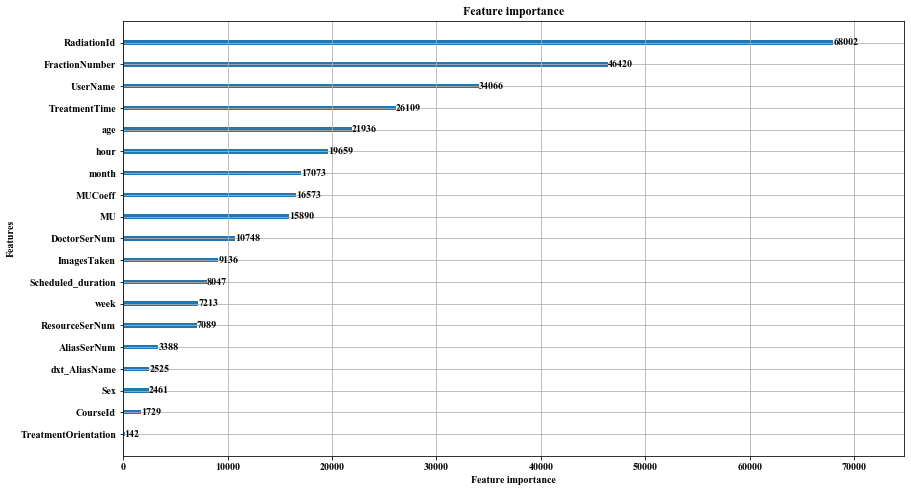

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))
lgb.plot_importance(gbm.booster_, max_num_features=len(test_x.columns), ax=ax)

## 2.2 Model2
##### objective: mae
##### features: no Scheduled_duration

In [18]:
data_display_ = data_display.copy()
data_ = data.copy()
train_x_ = train_x.copy()
train_y_ = train_y.copy()
test_x_ = test_x.copy()
test_y_ = test_y.copy()

train_x_.drop(['Scheduled_duration'], axis = 1, inplace = True)
test_x_.drop(['Scheduled_duration'], axis = 1, inplace = True)

In [19]:
# 创建模型，训练模型
print('='*40)
print('Train model')
gbm_sch = lgb.LGBMRegressor(objective='mae', num_leaves=15, learning_rate=0.05,
                        n_estimators = 100000)#num_leaves=31
gbm_sch.fit(
    train_x_[: int(train_x_.shape[0] * 0.9)], train_y_[: int(train_y_.shape[0] * 0.9)],
    eval_set=[(train_x_[int(train_x_.shape[0] * 0.9):], train_y_[int(train_y_.shape[0] * 0.9):])],
    eval_metric=['mape', 'rmse', 'mae'],
    early_stopping_rounds=100,
    verbose=200
)

Train model
Training until validation scores don't improve for 100 rounds
[200]	valid_0's mape: 0.240071	valid_0's rmse: 7.7074	valid_0's l1: 5.31094
[400]	valid_0's mape: 0.234043	valid_0's rmse: 7.54056	valid_0's l1: 5.16843
[600]	valid_0's mape: 0.230423	valid_0's rmse: 7.44789	valid_0's l1: 5.08505
[800]	valid_0's mape: 0.22822	valid_0's rmse: 7.38788	valid_0's l1: 5.03207
[1000]	valid_0's mape: 0.227099	valid_0's rmse: 7.36019	valid_0's l1: 5.0062
[1200]	valid_0's mape: 0.226219	valid_0's rmse: 7.33938	valid_0's l1: 4.98729
[1400]	valid_0's mape: 0.225707	valid_0's rmse: 7.325	valid_0's l1: 4.97476
[1600]	valid_0's mape: 0.225045	valid_0's rmse: 7.30783	valid_0's l1: 4.95979
[1800]	valid_0's mape: 0.224505	valid_0's rmse: 7.2944	valid_0's l1: 4.94686
[2000]	valid_0's mape: 0.224123	valid_0's rmse: 7.28511	valid_0's l1: 4.93794
[2200]	valid_0's mape: 0.22376	valid_0's rmse: 7.2751	valid_0's l1: 4.92897
[2400]	valid_0's mape: 0.223352	valid_0's rmse: 7.26436	valid_0's l1: 4.91936
[2

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100000, n_jobs=-1, num_leaves=15, objective='mae',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [20]:
# 测试
pred_y_ = gbm_sch.predict(test_x_, num_iteration = gbm_sch.best_iteration_)

# pred_result = test_x_[['PatientSerNum', 'AppointmentSerNum']].copy()
pred_result_sch = pd.DataFrame({})
pred_result_sch['pred_duration'] = pred_y_
pred_result_sch['actual_duration'] = test_y_['Actual_duration'].tolist()

print(mae(pred_result_sch['pred_duration'], pred_result_sch['actual_duration']))

4.720601030808515


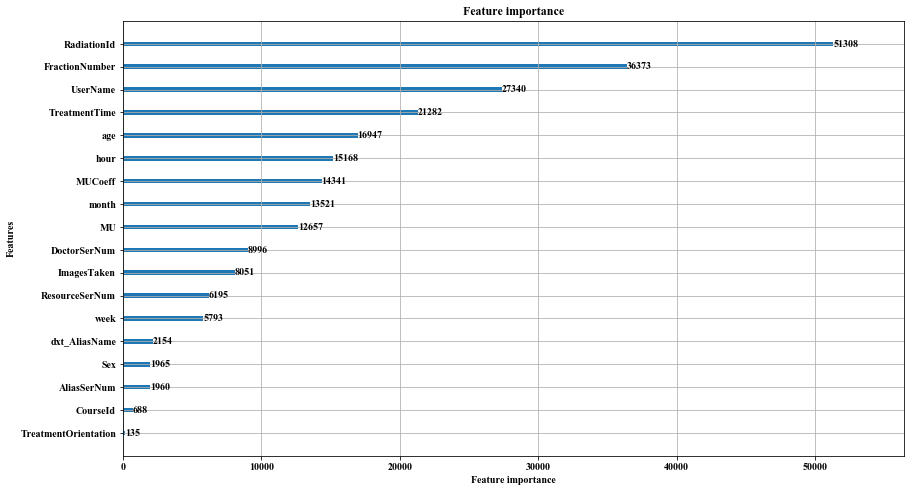

In [21]:
fig, ax = plt.subplots(figsize=(14, 8))
lgb.plot_importance(gbm_sch.booster_, max_num_features=len(test_x_.columns), ax = ax)

## 2.3 Model3
##### objective: rmse
##### features: Scheduled_duration

In [22]:
# 创建模型，训练模型
print('='*40)
print('Train model')
gbm_rmse = lgb.LGBMRegressor(objective='rmse', num_leaves=31, learning_rate=0.05,
                        n_estimators = 100000)
gbm_rmse.fit(
    train_x[: int(train_x.shape[0] * 0.9)], train_y[: int(train_y.shape[0] * 0.9)],
    eval_set=[(train_x[int(train_x.shape[0] * 0.9):], train_y[int(train_y.shape[0] * 0.9):])],
    eval_metric=['mape', 'rmse', 'mae'],
    early_stopping_rounds=100,
    verbose=200
)


Train model
Training until validation scores don't improve for 100 rounds
[200]	valid_0's mape: 0.239689	valid_0's l1: 4.85304	valid_0's rmse: 6.67148
[400]	valid_0's mape: 0.231012	valid_0's l1: 4.66178	valid_0's rmse: 6.42032
[600]	valid_0's mape: 0.224947	valid_0's l1: 4.52461	valid_0's rmse: 6.2363
[800]	valid_0's mape: 0.220119	valid_0's l1: 4.4124	valid_0's rmse: 6.08768
[1000]	valid_0's mape: 0.216124	valid_0's l1: 4.31919	valid_0's rmse: 5.96089
[1200]	valid_0's mape: 0.212737	valid_0's l1: 4.23879	valid_0's rmse: 5.85234
[1400]	valid_0's mape: 0.209638	valid_0's l1: 4.16698	valid_0's rmse: 5.75625
[1600]	valid_0's mape: 0.206817	valid_0's l1: 4.10399	valid_0's rmse: 5.67374
[1800]	valid_0's mape: 0.204133	valid_0's l1: 4.04413	valid_0's rmse: 5.59522
[2000]	valid_0's mape: 0.201907	valid_0's l1: 3.99253	valid_0's rmse: 5.52902
[2200]	valid_0's mape: 0.199445	valid_0's l1: 3.93681	valid_0's rmse: 5.45701
[2400]	valid_0's mape: 0.196966	valid_0's l1: 3.88205	valid_0's rmse: 5.38

[21000]	valid_0's mape: 0.127719	valid_0's l1: 2.43194	valid_0's rmse: 3.57861
[21200]	valid_0's mape: 0.127452	valid_0's l1: 2.42649	valid_0's rmse: 3.57178
[21400]	valid_0's mape: 0.127105	valid_0's l1: 2.41967	valid_0's rmse: 3.56371
[21600]	valid_0's mape: 0.126741	valid_0's l1: 2.41245	valid_0's rmse: 3.55528
[21800]	valid_0's mape: 0.126462	valid_0's l1: 2.407	valid_0's rmse: 3.54897
[22000]	valid_0's mape: 0.126163	valid_0's l1: 2.40114	valid_0's rmse: 3.54194
[22200]	valid_0's mape: 0.125883	valid_0's l1: 2.39557	valid_0's rmse: 3.5353
[22400]	valid_0's mape: 0.125546	valid_0's l1: 2.38909	valid_0's rmse: 3.5275
[22600]	valid_0's mape: 0.125213	valid_0's l1: 2.38247	valid_0's rmse: 3.5195
[22800]	valid_0's mape: 0.124833	valid_0's l1: 2.3752	valid_0's rmse: 3.51069
[23000]	valid_0's mape: 0.124443	valid_0's l1: 2.36761	valid_0's rmse: 3.50134
[23200]	valid_0's mape: 0.12417	valid_0's l1: 2.36209	valid_0's rmse: 3.49472
[23400]	valid_0's mape: 0.123797	valid_0's l1: 2.35472	vali

[42000]	valid_0's mape: 0.10396	valid_0's l1: 1.97403	valid_0's rmse: 3.03526
[42200]	valid_0's mape: 0.103837	valid_0's l1: 1.97162	valid_0's rmse: 3.03246
[42400]	valid_0's mape: 0.103666	valid_0's l1: 1.96843	valid_0's rmse: 3.02875
[42600]	valid_0's mape: 0.103483	valid_0's l1: 1.96502	valid_0's rmse: 3.02497
[42800]	valid_0's mape: 0.103343	valid_0's l1: 1.96226	valid_0's rmse: 3.02164
[43000]	valid_0's mape: 0.103164	valid_0's l1: 1.95905	valid_0's rmse: 3.01786
[43200]	valid_0's mape: 0.103005	valid_0's l1: 1.95612	valid_0's rmse: 3.01456
[43400]	valid_0's mape: 0.102853	valid_0's l1: 1.95331	valid_0's rmse: 3.01139
[43600]	valid_0's mape: 0.102685	valid_0's l1: 1.95022	valid_0's rmse: 3.00793
[43800]	valid_0's mape: 0.102564	valid_0's l1: 1.94792	valid_0's rmse: 3.00536
[44000]	valid_0's mape: 0.102402	valid_0's l1: 1.94493	valid_0's rmse: 3.00184
[44200]	valid_0's mape: 0.102284	valid_0's l1: 1.94267	valid_0's rmse: 2.99907
[44400]	valid_0's mape: 0.102135	valid_0's l1: 1.9399

[62600]	valid_0's mape: 0.0928519	valid_0's l1: 1.7665	valid_0's rmse: 2.80232
[62800]	valid_0's mape: 0.0927815	valid_0's l1: 1.76518	valid_0's rmse: 2.80086
[63000]	valid_0's mape: 0.0926948	valid_0's l1: 1.76355	valid_0's rmse: 2.7991
[63200]	valid_0's mape: 0.0926263	valid_0's l1: 1.76225	valid_0's rmse: 2.79763
[63400]	valid_0's mape: 0.0925529	valid_0's l1: 1.76085	valid_0's rmse: 2.79606
[63600]	valid_0's mape: 0.0924906	valid_0's l1: 1.75966	valid_0's rmse: 2.79482
[63800]	valid_0's mape: 0.0924281	valid_0's l1: 1.75851	valid_0's rmse: 2.79369
[64000]	valid_0's mape: 0.0923557	valid_0's l1: 1.75718	valid_0's rmse: 2.79229
[64200]	valid_0's mape: 0.0922987	valid_0's l1: 1.75613	valid_0's rmse: 2.79112
[64400]	valid_0's mape: 0.0922213	valid_0's l1: 1.75473	valid_0's rmse: 2.78956
[64600]	valid_0's mape: 0.0921366	valid_0's l1: 1.75311	valid_0's rmse: 2.78777
[64800]	valid_0's mape: 0.0920574	valid_0's l1: 1.75158	valid_0's rmse: 2.78606
[65000]	valid_0's mape: 0.0919917	valid_0'

[83200]	valid_0's mape: 0.0867804	valid_0's l1: 1.65367	valid_0's rmse: 2.68237
[83400]	valid_0's mape: 0.0867402	valid_0's l1: 1.65293	valid_0's rmse: 2.68158
[83600]	valid_0's mape: 0.0866955	valid_0's l1: 1.65211	valid_0's rmse: 2.68077
[83800]	valid_0's mape: 0.0866527	valid_0's l1: 1.65133	valid_0's rmse: 2.67994
[84000]	valid_0's mape: 0.0866191	valid_0's l1: 1.65071	valid_0's rmse: 2.67937
[84200]	valid_0's mape: 0.0865887	valid_0's l1: 1.65013	valid_0's rmse: 2.67869
[84400]	valid_0's mape: 0.086544	valid_0's l1: 1.64931	valid_0's rmse: 2.67788
[84600]	valid_0's mape: 0.0864914	valid_0's l1: 1.64838	valid_0's rmse: 2.67693
[84800]	valid_0's mape: 0.0864484	valid_0's l1: 1.64758	valid_0's rmse: 2.67607
[85000]	valid_0's mape: 0.0864152	valid_0's l1: 1.64694	valid_0's rmse: 2.67546
[85200]	valid_0's mape: 0.0863803	valid_0's l1: 1.64627	valid_0's rmse: 2.67475
[85400]	valid_0's mape: 0.0863541	valid_0's l1: 1.64578	valid_0's rmse: 2.67433
[85600]	valid_0's mape: 0.0863123	valid_0

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100000, n_jobs=-1, num_leaves=31, objective='rmse',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
# 测试
pred_y_rmse = gbm_rmse.predict(test_x, num_iteration = gbm_rmse.best_iteration_)

# pred_result = test_x[['PatientSerNum', 'AppointmentSerNum']].copy()
pred_result_rmse = pd.DataFrame({})
pred_result_rmse['pred_duration'] = pred_y_rmse
pred_result_rmse['actual_duration'] = test_y['Actual_duration'].tolist()

print(mae(pred_result_rmse['pred_duration'], pred_result_rmse['actual_duration']))

1.6123262011571486


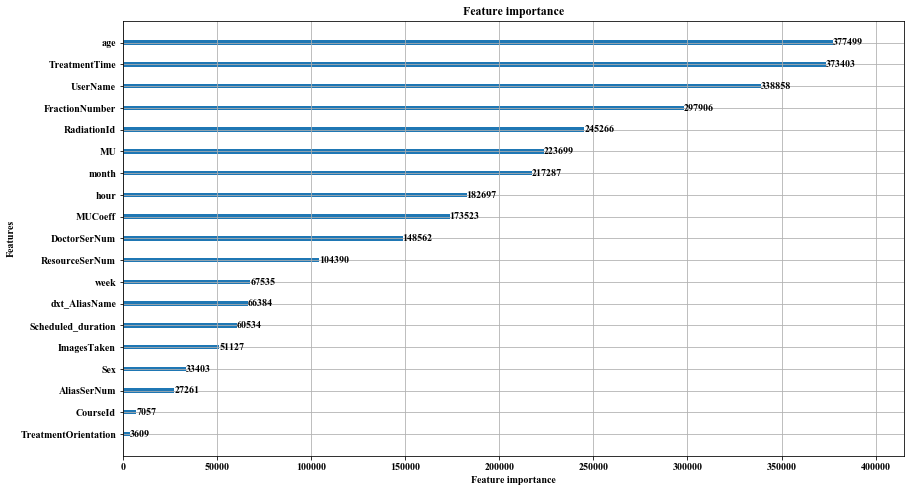

In [24]:
fig, ax = plt.subplots(figsize=(14, 8))
lgb.plot_importance(gbm_rmse.booster_, max_num_features=len(test_x.columns), ax = ax)

## 2.4 Model4
##### objective: mape
##### features: Scheduled_duration

In [25]:
# 创建模型，训练模型
print('='*40)
print('Train model')
gbm_mape = lgb.LGBMRegressor(objective='mape', num_leaves=31, learning_rate=0.05,
                        n_estimators = 100000)
gbm_mape.fit(
    train_x[: int(train_x.shape[0] * 0.9)], train_y[: int(train_y.shape[0] * 0.9)],
    eval_set=[(train_x[int(train_x.shape[0] * 0.9):], train_y[int(train_y.shape[0] * 0.9):])],
    eval_metric=['mape', 'rmse', 'mae'],
    early_stopping_rounds=100,
    verbose=200
)

Train model
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 7.89067	valid_0's l1: 5.18592	valid_0's mape: 0.212016
[400]	valid_0's rmse: 7.744	valid_0's l1: 5.06396	valid_0's mape: 0.207351
[600]	valid_0's rmse: 7.66188	valid_0's l1: 4.98935	valid_0's mape: 0.204405
[800]	valid_0's rmse: 7.60852	valid_0's l1: 4.94187	valid_0's mape: 0.202583
[1000]	valid_0's rmse: 7.59019	valid_0's l1: 4.9216	valid_0's mape: 0.201647
[1200]	valid_0's rmse: 7.5675	valid_0's l1: 4.89848	valid_0's mape: 0.200686
[1400]	valid_0's rmse: 7.55316	valid_0's l1: 4.88345	valid_0's mape: 0.20004
[1600]	valid_0's rmse: 7.54117	valid_0's l1: 4.87126	valid_0's mape: 0.199535
[1800]	valid_0's rmse: 7.53175	valid_0's l1: 4.8616	valid_0's mape: 0.199139
[2000]	valid_0's rmse: 7.52254	valid_0's l1: 4.85244	valid_0's mape: 0.198753
[2200]	valid_0's rmse: 7.51576	valid_0's l1: 4.84559	valid_0's mape: 0.198462
[2400]	valid_0's rmse: 7.50901	valid_0's l1: 4.8394	valid_0's mape: 0.19823
[2

KeyboardInterrupt: 

In [ ]:
# 测试
pred_y_mape = gbm_mape.predict(test_x, num_iteration = gbm_rmse.best_iteration_)

# pred_result = test_x[['PatientSerNum', 'AppointmentSerNum']].copy()
pred_result_mape = pd.DataFrame({})
pred_result_mape['pred_duration'] = pred_y_mape
pred_result_mape['actual_duration'] = test_y['Actual_duration'].tolist()

print(mae(pred_result_mape['pred_duration'], pred_result_mape['actual_duration']))

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
lgb.plot_importance(gbm_mape.booster_, max_num_features=len(test_x.columns), ax = ax)

# 3 shap

In [38]:
# print the JS visualization code to the notebook
shap.initjs()

##### 先将数据格式改变，这样后面能够正常显示分类变量

In [39]:
# # 仍然出现报错，无法使用
# feature_cate = ['dxt_AliasName', 'Sex', 'AliasSerNum', 
#                 'month', 'week', 'hour', 'date','DoctorSerNum', 
#                 'TreatmentOrientation', 'FractionNumber',
#                 'UserName', 'RadiationId', 'CourseId', 'ResourceSerNum']

# for col in feature_cate:
#     try:
#         data_train_display[col] = data_train_display.astype('category')
#         train_x[col] = train_x.astype(int)
#     except:
#         print(f'no column: {col}')

In [40]:
# 对于分类变量，需要显示原始变量值的话，就需要加载display
data_train_display = data_display[: int(data.shape[0] * 0.9)]
data_val_display = data_train_display[int(train_x.shape[0] * 0.9): ]
data_val_display.drop('Actual_duration', axis = 1, inplace = True)
data_val_display.reset_index(drop = True, inplace = True)

data_val = train_x[int(train_x.shape[0] * 0.9): ]

data_val_y = train_y[int(train_y.shape[0] * 0.9): ]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
explainer = shap.TreeExplainer(gbm.booster_)
shap_values = explainer.shap_values(data_val[: 1000])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [42]:
# 得到分类变量编码后的字典
def get_label_dic(col):
    # 关于concat 为什么ignore_index 不能用 https://segmentfault.com/a/1190000015370825
    feature_label = data_val[[col]].reset_index(drop = True, inplace = False)
    feature_value = data_val_display[[col]].reset_index(drop = True, inplace = False)

    features_name = pd.concat([feature_label, feature_value], ignore_index = False, axis = 1)
    features_name.drop_duplicates(inplace = True)
    features_name.reset_index(drop = True, inplace = True)
    return features_name

In [43]:
get_label_dic('Sex')

,Sex,Sex
0,1.0,Female
1,0.0,Female
2,1.0,Male
3,0.0,Male
4,2.0,Male


这是对于一个样本，每个特征的贡献程度。
以该样本为例，该样本的实际治疗时长为21.00min，模型给出的预测值为12.97min。
其中，age 和MU 这两个因素对于结果的贡献为正，其他特征对于结果的贡献为负，负贡献的特征，最主要的是Scheduled_duration、FractionNumber、dxt_AliasSerName和AliasSerNum。
从shapley value 的取值，我们可以看到每个特征具体的边际贡献值。
通过shap 对模型的归因，我们可以向每一位患者提供一些关于预期治疗时长的影响因素，从而缓解患者治疗时长不确定造成的紧张压力，同时因为患者的等待时长中，很大一部分的来源是序列中排前的患者的预期治疗时长，这些患者的预测归因，能够向排队患者提供等待时长的来源，比如因为前排患者大部分是高龄，女性，需要拍摄大量X 光片等。

In [44]:
data_val_y.iloc[1]

Actual_duration    15.0
Name: 492744, dtype: float64

In [45]:
data_val.iloc[1]

Scheduled_duration            15
age                           82
TreatmentTime           0.939677
ImagesTaken                    0
MU                       563.818
MUCoeff                      100
dxt_AliasName                 12
Sex                            1
AliasSerNum                    0
month                          8
week                           2
hour                           5
DoctorSerNum                  15
TreatmentOrientation           7
FractionNumber                 2
UserName                      23
RadiationId                  432
CourseId                       1
ResourceSerNum                 5
Name: 492744, dtype: object

In [46]:
shap_values[1]

array([-2.03261987,  0.27078605, -0.78524528, -0.21988319,  0.59659465,
       -0.2455963 , -1.8353872 , -0.18639196, -0.63471564,  0.71736232,
        0.16671786, -0.40889878, -0.01339774, -0.01031115, -0.42187341,
        0.41079012, -0.51231085, -0.06090081,  0.41268956])

In [50]:
# f = plt.gcf()

In [75]:
f = shap.force_plot(
    explainer.expected_value, 
    shap_values[1], 
    data_val.iloc[1])
# data_val_display.iloc[1]
f

<Figure size 432x288 with 0 Axes>

In [52]:
# pic_path = 'D:\\waiting time\\毕业设计\\中文报告\\论文图片\\'
# f.savefig(pic_path + '一个样本_force_plot.png')

In [53]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[: 1000], 
    data_val[: 1000])

密度散点图画出了所有样本的情况。纵向的特征的排序是按照shapley value的平均绝对值，也就是特征对于预测的贡献，贡献越大的特征，也就是更重要的特征。横轴表示具体的特征取值对于预测结果的贡献。
红色表示特征的取值更高，蓝色表示特征的取值更低。对于数值变量，我们可以从图像上直观地理解它们的含义。比如Scheduled_duration 越大，那么预测的Acutal_duration 则也倾向于更大。对于分类变量，由于我们已经进行了编码，所以图中的大小并没有数值意义上的大小含义，我们需要通过编码的字典来查找其对应的特征值。比如对于Sex，图中可见，Sex 的值越小，其对于预测值越大，反之则越小。如果对应Sex 的字典

index |特征编码|特征值 
-|-|-
0|0.0|Female
1|1.0|Male
2|2.0|Unknown

说明，如果Sex的信息未知，对预测结果有更大的负向影响，如果Sex 为女性，那么对预测结果有更大的正向影响，如果是男性，则对于影响并不显著。

每一个特征密度线的宽度表示密度。如果特征在某个点取值很多，那么密度线就会更宽。以Scheduled_duration为例，在我们全部的样本中，大量的样本人为的预期治疗时长都是15min，因此可以推断密度线中，非常宽的地方取值近似为15min，图中可以看出，15min的取值对于大部分预测贡献较小，且多为负向的作用；Scheduled_duration 对于预测贡献显著的样本，其取值多为15min 以上。这一结果也可以说明，为什么在去掉Scheduled_duration 这一特征后，我们的预测结果仅有较小程度的下降。

对于整体模型重要因素的分析，可以帮助医生更加清楚什么类型的患者可能会有更长的治疗时长，比如女性、高龄；通知更加清楚哪些环节造成治疗时长更长，比如X 光片的拍摄，更大剂量的放射治疗。同时有些非医疗环节的因素，同样会对治疗时长产生影响，比如治疗进行在上半年的月份，时长倾向于更短；发生在下半年，时长可能更长，可能这些非医疗因素，会对于某些操作、或者医患的状态造成影响，比如蒙特利尔所处纬度较高，寒冷的天气在下半年出现地较早，且持续时间长，寒冷的气候可能让患者适应治疗的时长变长，更厚重的衣物可能让医生的操作变慢，这些因素都需要更多维度的数据做进一步的挖掘。

In [55]:
data_val

,Scheduled_duration,age,TreatmentTime,ImagesTaken,MU,MUCoeff,dxt_AliasName,Sex,AliasSerNum,month,week,hour,DoctorSerNum,TreatmentOrientation,FractionNumber,UserName,RadiationId,CourseId,ResourceSerNum
492743,15.0,82,0.780898,0,468.550,100.0000,12.0,1.0,0.0,11.0,5.0,3.0,23.0,7.0,6.0,54.0,657.0,1.0,7.0
492744,15.0,82,0.939677,0,563.818,100.0000,12.0,1.0,0.0,8.0,2.0,5.0,15.0,7.0,2.0,23.0,432.0,1.0,5.0
492745,15.0,56,0.230746,0,138.447,100.0000,8.0,0.0,0.0,5.0,5.0,9.0,0.0,7.0,39.0,95.0,42.0,1.0,4.0
492746,30.0,74,0.231522,0,138.918,100.0000,5.0,1.0,0.0,6.0,1.0,4.0,11.0,7.0,10.0,50.0,945.0,1.0,2.0
492747,60.0,54,0.002917,0,161.442,93.6539,0.0,0.0,0.0,6.0,3.0,7.0,17.0,7.0,2.0,90.0,12.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547455,15.0,74,0.541915,2,325.151,100.0000,13.0,1.0,0.0,4.0,1.0,7.0,6.0,7.0,40.0,76.0,657.0,1.0,2.0
547456,30.0,55,0.312333,2,187.053,176.7330,7.0,0.0,0.0,8.0,3.0,7.0,0.0,7.0,22.0,56.0,1693.0,10.0,1.0
547457,15.0,70,0.002833,1,385.124,96.3303,9.0,0.0,1.0,10.0,1.0,10.0,1.0,3.0,0.0,42.0,534.0,11.0,6.0
547458,15.0,53,0.262316,0,157.405,100.0000,14.0,1.0,0.0,0.0,1.0,8.0,23.0,7.0,42.0,27.0,42.0,1.0,3.0


In [57]:
shap_values.shape

(1000, 19)

In [58]:
data_val.shape

(49822, 19)

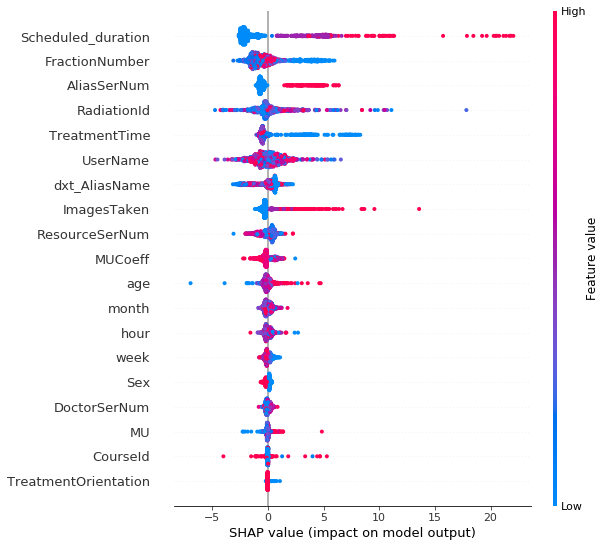

In [59]:
# summarize the effects of all the features
shap.summary_plot(shap_values, data_val[: 1000])

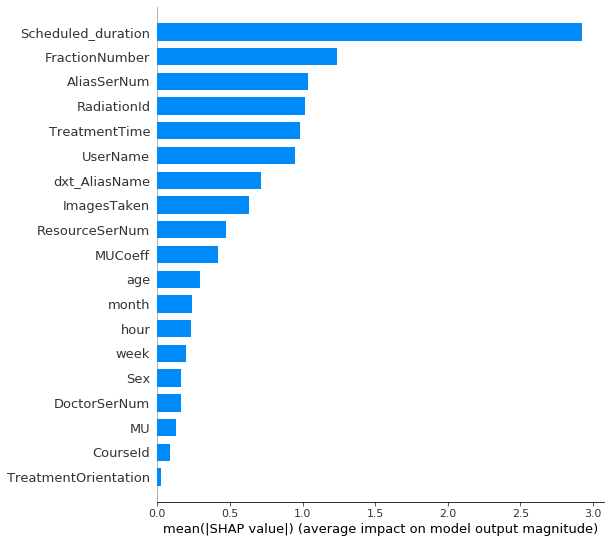

In [60]:
# summarize the effects of all the features
shap.summary_plot(shap_values, data_val, plot_type = 'bar')

feature dependence_plot: Scheduled_duration


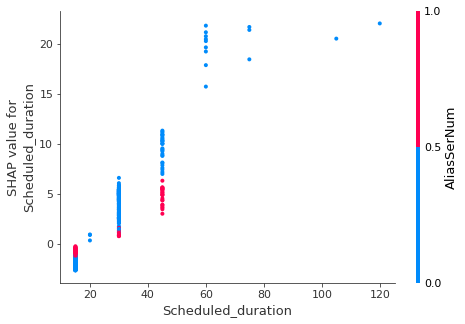

feature dependence_plot: age


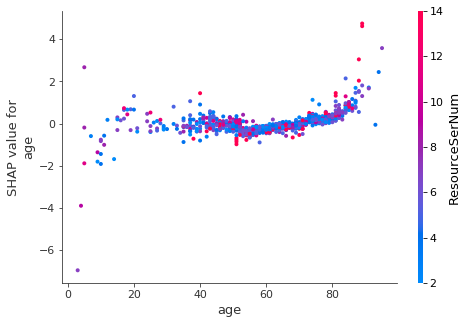

feature dependence_plot: TreatmentTime


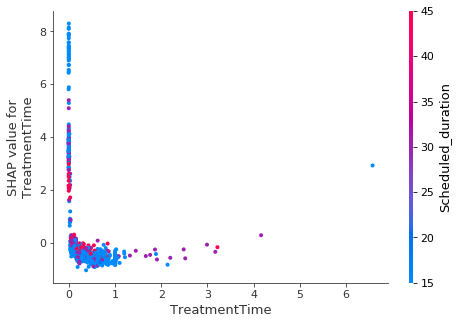

feature dependence_plot: ImagesTaken


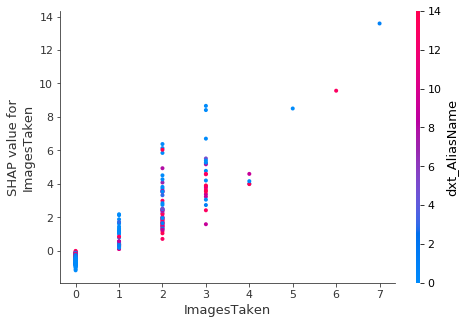

feature dependence_plot: MU


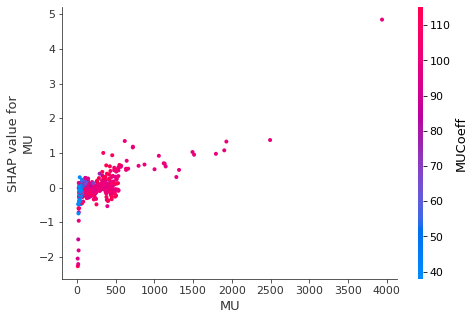

feature dependence_plot: MUCoeff


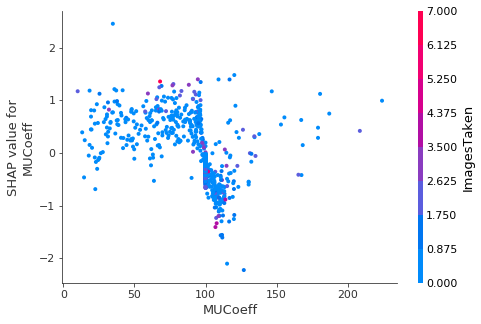

feature dependence_plot: dxt_AliasName


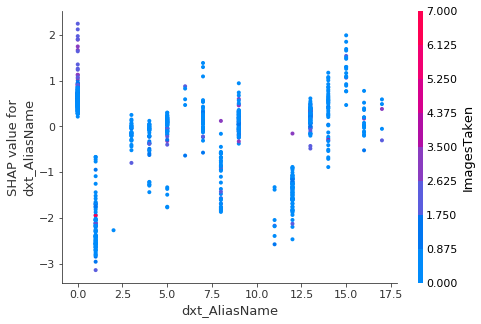

feature dependence_plot: Sex


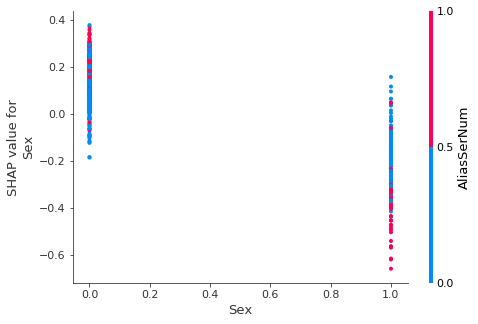

feature dependence_plot: AliasSerNum


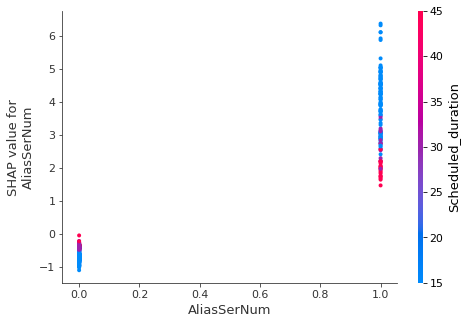

feature dependence_plot: month


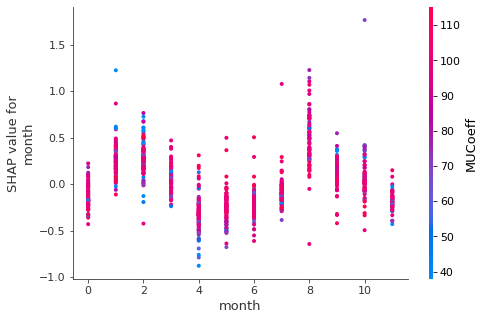

feature dependence_plot: week


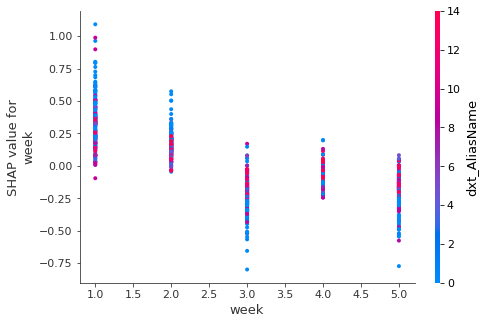

feature dependence_plot: hour


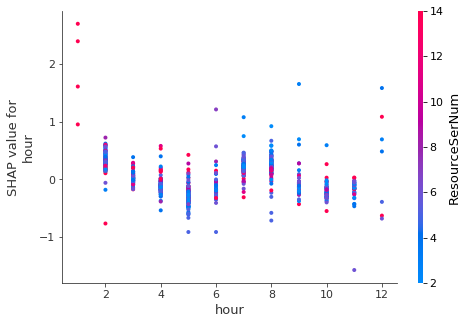

feature dependence_plot: DoctorSerNum


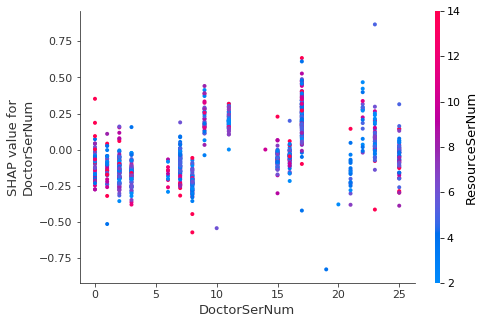

feature dependence_plot: TreatmentOrientation


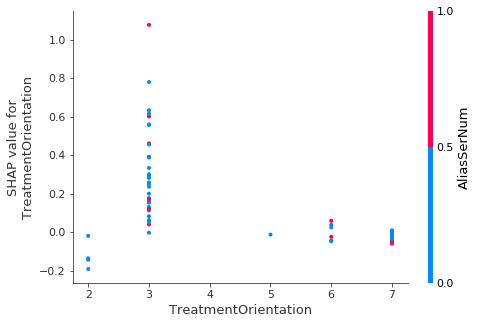

feature dependence_plot: FractionNumber


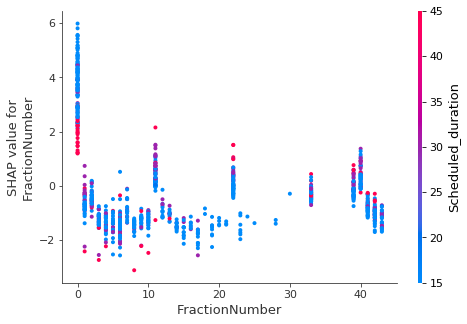

feature dependence_plot: UserName


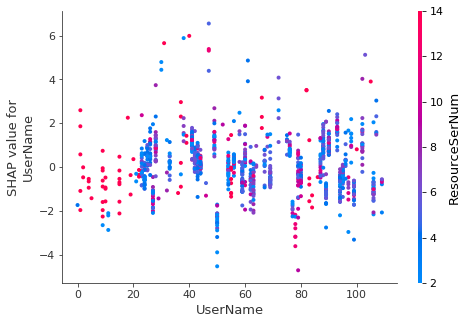

feature dependence_plot: RadiationId


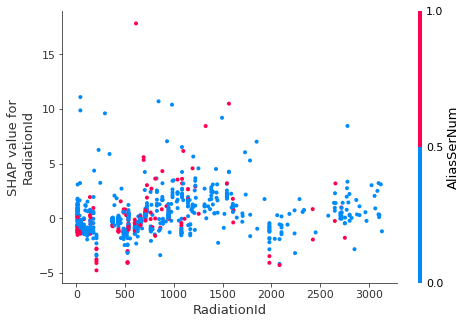

feature dependence_plot: CourseId


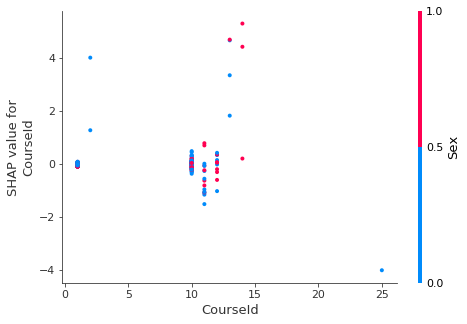

feature dependence_plot: ResourceSerNum


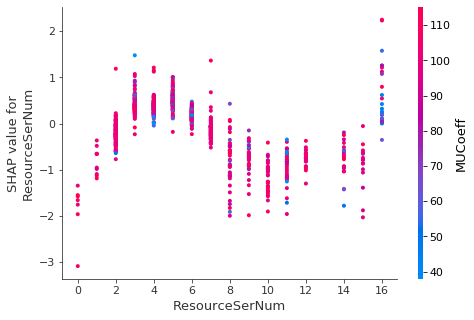

In [61]:
for col in data_val.columns:
    print(f'feature dependence_plot: {col}')
    shap.dependence_plot(
        col, 
        shap_values[: 1000], 
        data_val[: 1000])
    # display_features=X_display

==============================================================

# 4 Plot Prediction Result

In [62]:
import matplotlib.pyplot as plt

In [63]:
plot_data = pd.DataFrame({'Actual_duration': test_y.Actual_duration.tolist(),
                          'Scheduled_duration': test_x.Scheduled_duration.tolist(),
                          'pred_y': pred_y})
plot_data.sort_values(by = ['Actual_duration', 'Scheduled_duration', 'pred_y'], inplace = True)

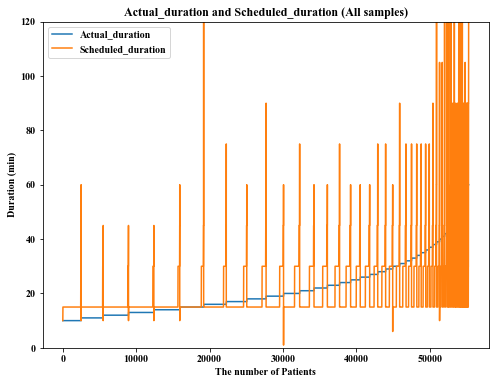

In [78]:
plot_data.sort_values(by = ['Actual_duration', 'Scheduled_duration'], inplace = True)
fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)
x = range(len(pred_y))
y1 = plot_data.Actual_duration.tolist()
y2 = plot_data.Scheduled_duration.tolist()
y3 = plot_data.pred_y.tolist()
ax.plot(x, y1, label = 'Actual_duration')
ax.plot(x, y2, label = 'Scheduled_duration')
# ax.plot(x, y3, label = 'pred_y')
ax.set_ylim(0, 120)
ax.set_xlabel('The number of Patients')
ax.set_ylabel('Duration (min)')
ax.set_title('Actual_duration and Scheduled_duration (All samples)')
ax.legend()
plt.show()

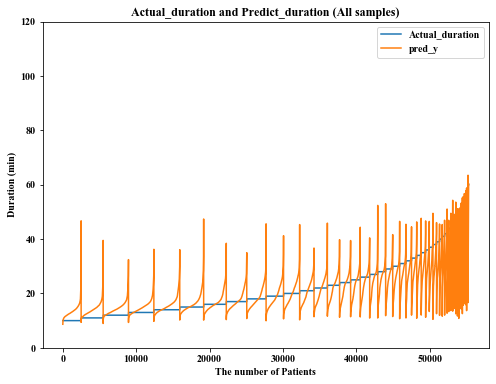

In [80]:
plot_data.sort_values(by = ['Actual_duration', 'pred_y'], inplace = True)
fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)
x = range(len(pred_y))
y1 = plot_data.Actual_duration.tolist()
y2 = plot_data.Scheduled_duration.tolist()
y3 = plot_data.pred_y.tolist()
ax.plot(x, y1, label = 'Actual_duration')
# ax.plot(x, y2, label = 'Scheduled_duration')
ax.plot(x, y3, label = 'pred_y')
ax.set_ylim(0, 120)
ax.set_xlabel('The number of Patients')
ax.set_ylabel('Duration (min)')
ax.set_title('Actual_duration and Predict_duration (All samples)')
ax.legend()
plt.show()

计算测试集中每一个样本的mae，我们可以更细致地观察我们的预测结果。样本中最大的mae为44.56min，其中mae在5min以内的样本占比为0.7348。
从可视化的结果，可以直观地看出，预测值在真实值的两侧波动，少量数据会有显著的异常差异，这部分数据可能导致我们最终的mae偏大。
在删除mae>5min之后的样本之后，可以看出我们的模型较好地捕捉到了治疗时长变化的趋势。

我们在筛选样本的时候比较粗略，实际情况中的治疗时长异常值无法被完全剔除，同时样本中可能存在信息覆盖的问题，mae过大的数据可能来源于异常样本。

在只保留mae 在3min 以内的样本，可视化的结果可以看出，模型捕捉到了治疗时长的变化趋势。对比医生预测的Scheduled_duration，同样在保留mae 在5min 以内的样本，从可视化后的结果看出，医生的预测，更倾向于给大多数患者一个平均治疗时长的预测，这种预测忽略了很多特殊原因导致治疗时长较长的患者。总体而言，医生的预测并没有真正捕捉到治疗时长的变化趋势，而序列中治疗时长较长的患者，就会造成后续患者等待时长的严重不准确，所以可能造成患者的紧张不安，增加对于医疗服务系统的不满。

In [81]:
# 误差样本比例
print('Scheduled_duration')
plot_data['mae_sch'] = np.abs(plot_data.Actual_duration - plot_data.Scheduled_duration)
print(f'plot_data {plot_data.shape}')
# plot_data_ = plot_data[plot_data.mae_sch <= 3]
# print(f'plot_data {plot_data_.shape}')
# print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')

# plot_data_ = plot_data[plot_data.mae_sch <= 10]
# print(f'plot_data {plot_data_.shape}')
# print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')

plot_data_ = plot_data[plot_data.mae_sch <= 15]
print(f'plot_data {plot_data_.shape}')
print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')

print('\npred_y')
plot_data['mae'] = np.abs(plot_data.Actual_duration - plot_data.pred_y)
print(f'plot_data {plot_data.shape}')
# plot_data_ = plot_data[plot_data.mae <= 3]
# print(f'plot_data {plot_data_.shape}')
# print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')

# plot_data_ = plot_data[plot_data.mae <= 10]
# print(f'plot_data {plot_data_.shape}')
# print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')


plot_data_ = plot_data[plot_data.mae <= 15]
print(f'plot_data {plot_data_.shape}')
print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')

Scheduled_duration
plot_data (55288, 4)
plot_data (48339, 4)
precent 0.8743126899146288

pred_y
plot_data (55288, 5)
plot_data (52637, 5)
precent 0.9520510779916076


Scheduled_duration

pred_y


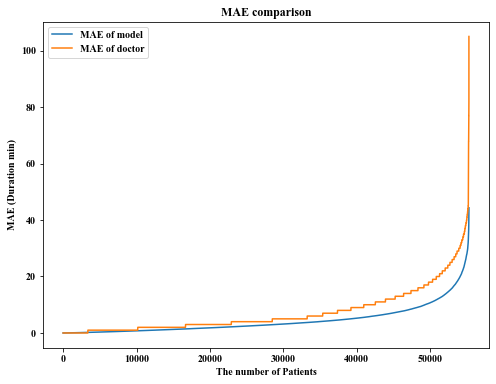

In [82]:
# 误差样本比例
print('Scheduled_duration')
plot_data['mae_sch'] = np.abs(plot_data.Actual_duration - plot_data.Scheduled_duration)
print('\npred_y')
plot_data['mae'] = np.abs(plot_data.Actual_duration - plot_data.pred_y)


fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)
x = range(plot_data.shape[0])
y1 = plot_data.mae.tolist()
y1.sort()
y2 = plot_data.mae_sch.tolist()
y2.sort()
ax.plot(x, y1, label = 'MAE of model')
ax.plot(x, y2, label = 'MAE of doctor')
ax.set_xlabel('The number of Patients')
ax.set_ylabel('MAE (Duration min)')
ax.set_title('MAE comparison')
ax.legend()
plt.show()

plot_data (55288, 5)
plot_data (22910, 5)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


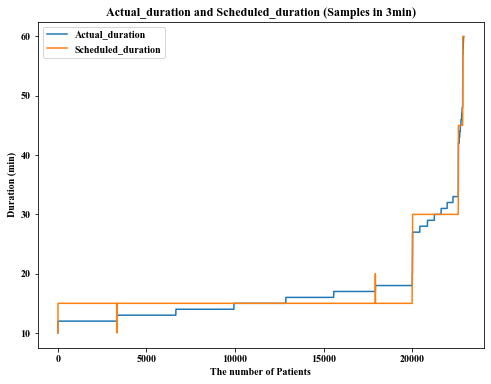

In [84]:
plot_data['mae_sch'] = np.abs(plot_data.Actual_duration - plot_data.Scheduled_duration)
print(f'plot_data {plot_data.shape}')
plot_data_ = plot_data[plot_data.mae_sch <= 3]
print(f'plot_data {plot_data_.shape}')
plot_data_.sort_values(by = ['Actual_duration', 'Scheduled_duration'], inplace = True)
fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)
x = range(plot_data_.shape[0])
y1 = plot_data_.Actual_duration.tolist()
y2 = plot_data_.Scheduled_duration.tolist()
y3 = plot_data_.pred_y.tolist()
ax.plot(x, y1, label = 'Actual_duration')
ax.plot(x, y2, label = 'Scheduled_duration')# linestyle=':'
# ax.plot(x, y3, label = 'pred_y')
ax.set_xlabel('The number of Patients')
ax.set_ylabel('Duration (min)')
ax.set_title('Actual_duration and Scheduled_duration (Samples in 3min)')
ax.legend()
plt.show()

plot_data (55288, 5)
plot_data (28909, 5)
precent 0.5228801909998553



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


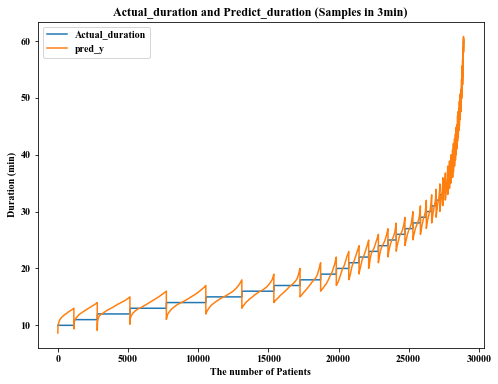

In [83]:
## plot_data['mae'] = np.abs(plot_data.Actual_duration - plot_data.pred_y)
print(f'plot_data {plot_data.shape}')
plot_data_ = plot_data[plot_data.mae <= 3]
print(f'plot_data {plot_data_.shape}')
print(f'precent {plot_data_.shape[0] / plot_data.shape[0]}')
plot_data_.sort_values(by = ['Actual_duration', 'pred_y'], inplace = True)

fig = plt.figure(figsize = (8, 6))
ax = plt.subplot(111)
x = range(plot_data_.shape[0])
y1 = plot_data_.Actual_duration.tolist()
y2 = plot_data_.Scheduled_duration.tolist()
y3 = plot_data_.pred_y.tolist()
ax.plot(x, y1, label = 'Actual_duration')
# ax.plot(x, y2, label = 'Scheduled_duration')
ax.plot(x, y3, label = 'pred_y')
ax.set_xlabel('The number of Patients')
ax.set_ylabel('Duration (min)')
ax.set_title('Actual_duration and Predict_duration (Samples in 3min)')
ax.legend()
plt.show()